In [2]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint
import pywt

import os
import struct
import matplotlib
from scipy import signal
import scipy.fftpack
import numpy as np
import sys
import pymongo
import json
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [4]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [63]:
testParse = '/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00009842/s002_2013_04_01/00009842_s002_t000.edf'
nTestSignals = 32
decodeRecords = 32
seekToDecode = (256-32)*nTestSignals+256

testOut = open(testParse,'rb')
#testOut.seek(256)
print(testOut.read(512))
testOut.seek(252)
print("Signals: ",testOut.read(4))
print("------------------------End of file header-----------------------------------")
print(testOut.read(nTestSignals*(256-128)))
print(testOut.tell())
testOut.seek(seekToDecode)
print("------------------------------")
unpackString = ''
for x in range(nTestSignals*16):
    unpackString = unpackString + str(struct.unpack('h',testOut.read(2)))
print(unpackString)

b'0       00009842                                                                        Startdate 01-APR-2013 00009842_s002                                             01.04.1315.29.157168    EDF                                         300     1.00000027  EEG FP1-REF     EEG FP2-REF     EEG F3-REF      EEG F4-REF      EEG C3-REF      EEG C4-REF      EEG P3-REF      EEG P4-REF      EEG O1-REF      EEG O2-REF      EEG F7-REF      EEG F8-REF      EEG T3-REF      EEG T4-REF      EEG T5-REF      EEG T6-REF      '
Signals:  b'27  '
------------------------End of file header-----------------------------------
b'EEG FP1-REF     EEG FP2-REF     EEG F3-REF      EEG F4-REF      EEG C3-REF      EEG C4-REF      EEG P3-REF      EEG P4-REF      EEG O1-REF      EEG O2-REF      EEG F7-REF      EEG F8-REF      EEG T3-REF      EEG T4-REF      EEG T5-REF      EEG T6-REF      EEG T1-REF      EEG T2-REF      EEG FZ-REF      EEG CZ-REF      EEG PZ-REF      EEG EKG1-REF    EEG A1-REF      EEG A2-REF      IB

In [101]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = str(label)
        self.sampleRate = int(sampleRate)
        self.transducer = str(transducer)
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = int(channelIndex)
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            returnString = ("Label: "+str(self.label) + "\nSample Rate"+str(self.sampleRate)+
            "\nTransducer: "+str(self.transducer)+"\nDimensions: "+str(self.dimensions)+
            "\nphysMin: "+str(self.physMin)+"\nphysMax: "+str(self.physMax)+
            "\ndigMin: "+str(self.digMin) +"\ndigMax: "+str(self.digMax)+ "\npreFilter: "+str(self.preFilter)+
            "\nNotes: "+str(self.notes) + "\nChannelIndex: "+str(self.channelIndex) + "\nbyteLength: "+str(self.byteLength))
        return returnString
    
    def channelData(self,start,duration,channelNumber = 0,sensitivity = 1):
        '''
        Returns data points of all signals from start time for duration
        start: seconds from start of record
        duration: time  of record desired in seconds
        byteLength: Length of each record per unit duration
        channelIndex: index in record
        '''
        headerLength = self.edfFile.getHeaderBytes()
        
        bytesToRead = self.sampleRate * self.edfFile.getDuration()
        channelDataToReturn = []
        recordByteLength = self.edfFile.getRecordByteLength()
        numSkipRecordBytes = start * recordByteLength
        print("IN CHANNEL DATA FUNCTION")
        print("Channel Sample Rate: ",self.sampleRate)
        print("Sample Durations: ",self.edfFile.getDuration())
        print("Channel Index: ",self.channelIndex)
        print("Skipping: ",numSkipRecordBytes)
        print("Record Byte Length: ",recordByteLength)
        print("headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i")
        print("Read INDEX: ",(headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength))
        samplesToRead = int(self.sampleRate/2)
        for i in range(duration):
            print("I VALUE RIGHT NOW IS: ",i)
            readIndex = headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
            self.edfFile.edfRawData.seek(readIndex)
            print("Getting DATA FROM INDEX:  ",readIndex)
            for j in range(samplesToRead):
                channelDataToReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
            print("READ DATA TO INDEX: ",self.edfFile.edfRawData.tell())
        return channelDataToReturn

    def allChannelData(self):
        toReturn = []
        self.edfFile.edfRawData.seek(self.channelIndex)
        for i in range(int(self.byteLength/2)):
            toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
        return toReturn
        
    def getLabel(self):
        return str(self.label)
    
    def getSampleRate(self):
        return self.sampleRate
    
    def getChannelIndex(self):
        return self.channelIndex
    
    def getTransducer(self):
        return self.transducer

    def getDimensions(self):
        return self.dimensions
    
    def getPhysMin(self):
        return float(self.physMin)
    
    def getPhysMax(self):
        return float(self.physMax)
    
    def getDigMin(self):
        return float(self.digMin)
    
    def getDigMax(self):
        return float(self.digMax)
    
    def getPreFilter(self):
        return self.preFilter
    
    def getNotes(self):
        return self.notes
    
    def getByteLength(self):
        return self.byteLength
    
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nPatient Id: "+str(self.patientId) 
                + "\nrecordId" + str(self.recordId) + "\nStart Date: " + str(self.startTime)
                + "\nStart Time: " + str(self.startTime)
                + "\nheader Bytes: " + str(self.headerBytes) +"\nReserve Bytes: " +str(self.reservedBytes)
                + "\nNum Records :" + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nDuration: "+ str(self.duration) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(10000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
    
    def readSignalHeaderBits(self,bitsIn,nSignals,nBits):
            returnArray = []
            for x in range(nSignals):
                returnArray.append(bitsIn.read(nBits))
            return returnArray
        
    def returnChannelObjects(self):
        return self.channels
    
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        print(self.edfRawData.tell()) #
        self.edfRawData.seek(0)       #
        self.version = str(self.edfRawData.read(8))
        self.patientId = str(self.edfRawData.read(80))
        self.recordId = str(self.edfRawData.read(80))
        self.startDate = str(self.edfRawData.read(8))
        self.startTime = str(self.edfRawData.read(8))
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = str(self.edfRawData.read(44))
        self.nRecords = int(self.edfRawData.read(8))
        print("nRecords: ",self.nRecords)
        self.duration = float(self.edfRawData.read(8))
        print("Duration: ",self.duration)
        self.nSignals = int(self.edfRawData.read(4))
        print("N Signals: ",self.nSignals)
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,16)
        self.channels['transducer'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['dimensions'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['preFilter'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['sampleRate'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['reservedNotes'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,32)
        print("SAMPLE RATES: ",self.channels['sampleRate'])
        sumOfSampleRates = 0
        for x in self.channels['sampleRate']:
            sumOfSampleRates += int(x)
        self.recordByteLength = sumOfSampleRates * 2
        #print("EDF CHANNEL PRINT: ",self.channels['reservedNotes'])
        
        self.channelObjects = []
        self.sampleRate = int(self.channels['sampleRate'][0])
        
        channelDataStart = self.headerBytes
    
        #This loop creates and adds channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            channelRecordIndex = sum(list(np.array(self.channels['sampleRate']).astype(int))[0:i])*2
            
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            newChannel = channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],channelDataStart,self.recordByteLength) 
            print("Appending channel")
            print(newChannel)
            self.channelObjects.append(channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelRecordIndex))  #Changed this channelIndex to channelDataStart
            
            #channelDataStart += byteLength
    
    
        self.channelSampleRates = channelValues['sampleRate'] 
        self.channelDigMax = channelValues['digMax']
        self.channelDigMin = channelValues['digMin']
        self.channelPhysMax = channelValues['physMax']
        self.channelPhysMin = channelValues['physMin']
            
    def data(self,start,duration):
        sampleData = []
        j = 0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration)])
            j+=1
        return sampleData
    
    def dataDictionary(self,start,duration):
        sampleData = {}
        j = 0
        #Returns dictionary with key being channel label, values being a dict [data,sampleRate,digMax,digMin,physMax,physMin]
        for i,x in enumerate(self.channelObjects):
            dataToAdd = x.channelData(start,duration,i)   
            #print("ADDING TO DATA DICTIONARY: ",x.getLabel())
            sampleData[x.getLabel()]={'data':dataToAdd,'sampleRate':x.getSampleRate(),
                                     'digMax':x.getDigMax(),'digMin':x.getDigMin(),'physMin':x.getPhysMin(),
                                     'physMax':x.getPhysMax()}
            #print(x)
            j+=1
        return sampleData
    
    def dataForGraph(self,start,duration,sensitivity=1):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration,j,sensitivity)])
            j+=1
        return sampleData
    
    def allData(self):
        '''
        Return[sampleRate,{channelData}]
        '''
        channelData = {}
        for x in self.channelObjects:
            channelData[str(x.getLabel())]=x.allChannelData()
        return[int(self.sampleRate),channelData]
            
            
    
    def patientId(self):
        return self.patientId
    
    def recordId(self):
        return self.recordId
    
    def startDate(self):
        return self.startDate
    
    def startTime(self):
        return self.startTime
    
    def getHeaderBytes(self):
        return self.headerBytes
    
    def reservedBytes(self):
        return self.reservedBytes
    
    def getDuration(self):
        return self.duration
    
    def nRecords(self):
        return self.nRecords
    
    def numSignals(self):
        return self.nSignals
    
    def getSampleRate(self):
        return int(self.sampleRate)
    
    def getRecordByteLength(self):
        return self.recordByteLength

    def channelLabels(self):
        labels = []
        for channel in self.channelObjects:
            labels.append(channel.label())
        return labels
    
    def returnChannelObjects(self):
        return self.channels
    
    def totalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[2])

In [114]:
'''
Plotting Functions
'''
    
    
def plotEDF(edfObject,montageArray,startPlot,endPlot,scaleFactor = 1,maxIndexMarkers=False):
    
    edfDataDictionary = edfObject.dataDictionary(startPlot,endPlot)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    
    for n,x in enumerate(montageArray):
        channel1 = x[0]
        channel2 = x[1]
        channel1Label = dataDictionaryKeys[channel1]
        channel2Label = dataDictionaryKeys[channel2]
        
        channel1DigMax = edfDataDictionary[channel1Label]['digMax']
        channel1PhysMax = edfDataDictionary[channel1Label]['physMax']
        channel2DigMax = edfDataDictionary[channel1Label]['digMax']
        channel2PhysMax = edfDataDictionary[channel1Label]['physMax']
        
        channel1ScaleFactor = channel1PhysMax/channel1DigMax
        channel2ScaleFactor = channel2PhysMax/channel2DigMax
        
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        
        #plotData = input1Data - input2Data
        plotData = np.subtract(input1Data,input2Data)
    
        scaledAndMoved = plotData*scaleFactor +(-n*40)
        
        #print(plotData[0:10])
        #print(scaledAndMoved[0:10])
        channelAverageHeight = np.average(scaledAndMoved)
        
        channelsInMontage = len(montageArray)
        vLineHeight = 1/channelsInMontage
        
        if maxIndexMarkers == True:
            channelMax = max(plotData)
            maxIndex = list(plotData).index(channelMax)
            lineStart = 1-((n+2)*(vLineHeight))
            lineEnd = 1-(n*vLineHeight)
            plt.text(maxIndex,channelAverageHeight+60,("Index: "+str(maxIndex)+" Value: "+str(channelMax)))
            #plt.axes().axvline(maxIndex,i*vLineHeight,(i+1)*vLineHeight).set_color('green') This one is if plots aren't started from the bottom
            plt.axes().axvline(maxIndex,lineStart,lineEnd).set_color('green')

        #plt.text(maxIndex,channelAverageHeight+60,("Channel: ",str(x)," Max Index: ",str(maxIndex)))
        plt.text(0,channelAverageHeight+3,(str(channel1Label)+" - "+str(channel2Label)))

        plt.plot(scaledAndMoved)  #Change back to scaledAndMoved

    plt.show()
    
    
def plotQuadrantSpike(edfObject,quadrantArray,montageArray,quadrantToPlot,indexToPlot,timeSpan):
    '''
    Plot quadrant spike at specified index and quadrant
    '''
    sampleRate = edfObject.getSampleRate()
    startSecond = indexToPlot-(sampleRate/2)/sampleRate
    vLineLocation = sampleRate/2
    edfDataDictionary = edfObject.dataDictionary(startSecond,timeSpan)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    quadrantChannels = quadrantArray[quadrantToPlot]
    for i,x in enumerate(quadrantChannels):
        channel1 = montageArray[x][0]
        channel2 = montageArray[x][1]
        channel1Label = dataDictionaryKeys[channel1]
        channel2Label = dataDictionaryKeys[channel2]
        
        channel1DigMax = edfDataDictionary[channel1Label]['digMax']
        channel1PhysMax = edfDataDictionary[channel1Label]['physMax']
        channel1SampleRate = edfDataDictionary[channel1Label]['sampleRate']
        channel2DigMax = edfDataDictionary[channel1Label]['digMax']
        channel2PhysMax = edfDataDictionary[channel1Label]['physMax']
        
        channel1ScaleFactor = float(channel1PhysMax/channel1DigMax)
        channel2ScaleFactor = float(channel2PhysMax/channel2DigMax)
        #print("Channel2SCALE FACTOR: ",channel2ScaleFactor)
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * float(channel1ScaleFactor)
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * float(channel2ScaleFactor)

        plotData = input1Data - input2Data

        scaledAndMoved = plotData +(-i*600)
        channelAverageHeight = np.average(scaledAndMoved)
        plt.axes().axvline(vLineLocation,0,1).set_color('red')
        plt.text(0,channelAverageHeight+60,(str(channel1Label)+" - "+str(channel2Label)))
        plt.plot(scaledAndMoved)
    plt.show()
        
        

In [ ]:
'''
Global Variables
'''

#Longitudinal Bipolar Montage array
longBipolarMontage = [[0,10],[10,12],[12,14],[14,8],[0,2],[2,4],[4,6],[6,8],
                      [18,19],[19,20],[1,3],[3,5],[5,7],[7,9],[1,11],[11,13],[13,15],[15,9]]
czRefMontage = [[0,19],[10,19],[12,19],[14,19],[0,19],[2,19],[4,19],[6,19],
                      [18,19],[19,19],[1,19],[3,19],[5,19],[7,19],[1,19],[11,19],[13,19],[15,19]]
testMontage = [[1,21],[3,21],[5,21],[7,21],[9,21],[1,3],[3,5],[5,7],[7,9]]
testMontage2 = [[0,19],[1,19],[2,19],[3,19],[4,19],[5,19],[6,19],[7,19],[8,19],[9,19],[10,19],
                [11,19],[12,19],[13,19],[14,19],[15,19],[16,19],[17,19],[18,19],[19,19],[0,19],
                [10,19],[12,19],[14,19],[0,19],[2,19],[4,19],[6,19],
                [18,19],[19,19],[1,19],[3,19],[5,19],[7,19],[1,19],[11,19],[13,19],[15,19]]
#adjacentElectrodeArray is an array of arrays where each of the entries is a quadrant LAQ,LPQ,RAQ,RPQ
adjacentElectrodeArray = [[0,1,4,5],[2,6,3,7],[10,11,14,15],[12,11,13,17]] 

#Contains Many Spikes
trainingFile1 ='/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00009842/s001_2013_04_01/00009842_s001_t000.edf'
predictFile1 = '/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00009842/s002_2013_04_01/00009842_s002_t000.edf'
predictFile2 = '/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00010547/s001_2013_07_29/00010547_s001_t001.edf'

predictEDF1 = edfData(2)
predictEDF1.loadFile(predictFile2)
predictEDF1.parseEdf()

trainingEDF1 = edfData(1)
trainingEDF1.loadFile(trainingFile1)
trainingEDF1.parseEdf()



durationToCheck = 120  # Only search first 120 seconds of each sample
print(trainingEDF1)
print("\n",predictEDF1)


In [109]:
#testEDF1 = predictEDF1.dataDictionary(0,1)
#print(testEDF1.keys())
#for x in testEDF1:
#    print(testEDF1[x])
print(predictEDF1)
predictChannels = predictEDF1.returnChannelObjects()
print("Num Chanel Objects = ",len(predictChannels))
for x in predictChannels:
    print(type(x))
    print(x)
    
print("\n\n")
print(trainingEDF1)
trainingChannels = trainingEDF1.returnChannelObjects()
print("Num Chanel Objects = ",len(trainingChannels))
#for x in trainingChannels:
#    print(type(x))
#    print(x)
    
trainingDictionaryTest =  trainingEDF1.dataDictionary(0,10)

version: b'0       '
Patient Id: b'00010547                                                                        '
recordIdb'Startdate 29-JUL-2013 00010547_s001                                             '
Start Date: b'10.32.07'
Start Time: b'10.32.07'
header Bytes: 9472
Reserve Bytes: b'EDF                                         '
Num Records :1795
Num Signals :36
Duration: 1.0
File Size: 29637742
Num Chanel Objects =  10
<class 'str'>
labels
<class 'str'>
transducer
<class 'str'>
dimensions
<class 'str'>
physMin
<class 'str'>
physMax
<class 'str'>
digMin
<class 'str'>
digMax
<class 'str'>
preFilter
<class 'str'>
sampleRate
<class 'str'>
reservedNotes



version: b'0       '
Patient Id: b'00009842                                                                        '
recordIdb'Startdate 01-APR-2013 00009842_s001                                             '
Start Date: b'14.17.46'
Start Time: b'14.17.46'
header Bytes: 9472
Reserve Bytes: b'EDF                                   

READ DATA TO INDEX:  120258
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   136514
READ DATA TO INDEX:  136764
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   153020
READ DATA TO INDEX:  153270
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   169526
READ DATA TO INDEX:  169776
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  12000
Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  37978
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   21472
READ DATA TO INDEX:  21722
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   37978
READ DATA TO INDEX:  38228
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   54484
READ DATA TO INDEX:  54734
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   70990
READ DATA TO INDEX:  71240
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   87496
READ DATA TO INDEX:  87746
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   104002

0
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  0
Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  25978
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   9472
READ DATA TO INDEX:  9722
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   25978
READ DATA TO INDEX:  26228
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   42484
READ DATA TO INDEX:  42734
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   58990
READ DATA TO INDEX:  59240
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   75496
READ DATA TO INDEX:  75746
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   92002
READ DATA TO INDEX:  92252
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   108508
READ DATA TO INDEX:  108758
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   125014
READ DATA TO INDEX:  125264
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   141520
READ DATA TO INDEX:  141770
I VAL

Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  30478
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   13972
READ DATA TO INDEX:  14222
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   30478
READ DATA TO INDEX:  30728
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   46984
READ DATA TO INDEX:  47234
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   63490
READ DATA TO INDEX:  63740
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   79996
READ DATA TO INDEX:  80246
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   96502
READ DATA TO INDEX:  96752
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   113008
READ DATA TO INDEX:  113258
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   129514
READ DATA TO INDEX:  129764
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   146020
READ DATA TO INDEX:  146270
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   162526
READ DATA TO INDEX:  162776
IN CHANNEL

Getting DATA FROM INDEX:   38978
READ DATA TO INDEX:  39228
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   55484
READ DATA TO INDEX:  55734
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   71990
READ DATA TO INDEX:  72240
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   88496
READ DATA TO INDEX:  88746
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   105002
READ DATA TO INDEX:  105252
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   121508
READ DATA TO INDEX:  121758
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   138014
READ DATA TO INDEX:  138264
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   154520
READ DATA TO INDEX:  154770
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   171026
READ DATA TO INDEX:  171276
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  13500
Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  39478
I VALUE RIGHT NOW IS: 

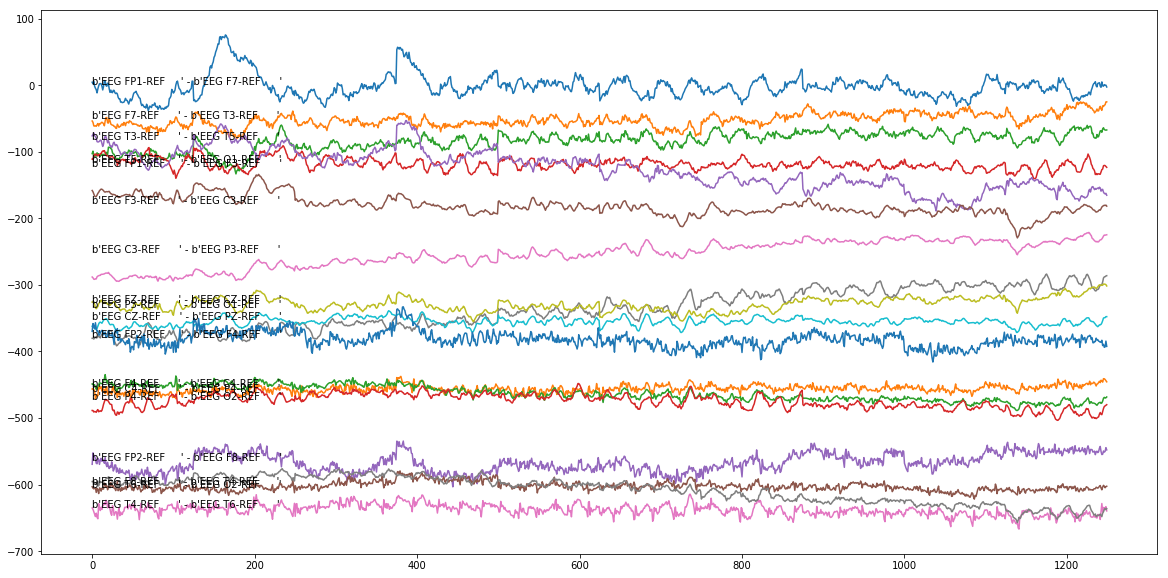

10
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  0
Skipping:  165060
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  191038
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   174532
READ DATA TO INDEX:  174782
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   191038
READ DATA TO INDEX:  191288
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   207544
READ DATA TO INDEX:  207794
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   224050
READ DATA TO INDEX:  224300
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   240556
READ DATA TO INDEX:  240806
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   257062
READ DATA TO INDEX:  257312
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   273568
READ DATA TO INDEX:  273818
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   290074
READ DATA TO INDEX:  290324
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   306580
READ DATA TO

Getting DATA FROM INDEX:   196038
READ DATA TO INDEX:  196288
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   212544
READ DATA TO INDEX:  212794
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   229050
READ DATA TO INDEX:  229300
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   245556
READ DATA TO INDEX:  245806
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   262062
READ DATA TO INDEX:  262312
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   278568
READ DATA TO INDEX:  278818
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   295074
READ DATA TO INDEX:  295324
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   311580
READ DATA TO INDEX:  311830
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   328086
READ DATA TO INDEX:  328336
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  5500
Skipping:  165060
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  196538
I VALUE R

READ DATA TO INDEX:  203288
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   219544
READ DATA TO INDEX:  219794
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   236050
READ DATA TO INDEX:  236300
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   252556
READ DATA TO INDEX:  252806
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   269062
READ DATA TO INDEX:  269312
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   285568
READ DATA TO INDEX:  285818
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   302074
READ DATA TO INDEX:  302324
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   318580
READ DATA TO INDEX:  318830
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   335086
READ DATA TO INDEX:  335336
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  12500
Skipping:  165060
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  203538
I VALUE RIGHT NOW IS:  0
Getting DATA FROM

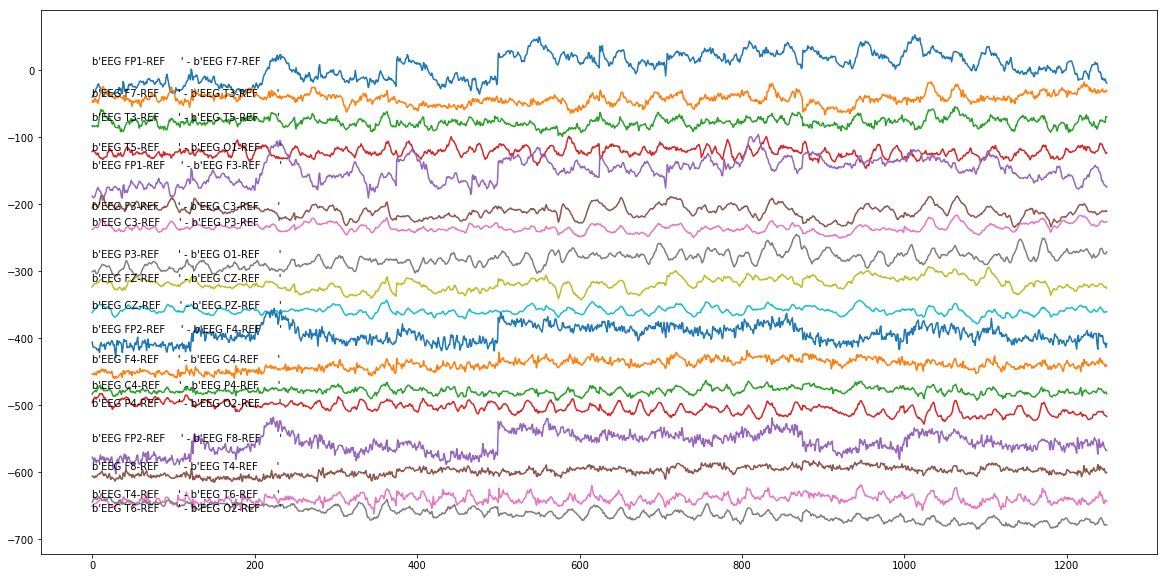

20
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  0
Skipping:  330120
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  356098
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   339592
READ DATA TO INDEX:  339842
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   356098
READ DATA TO INDEX:  356348
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   372604
READ DATA TO INDEX:  372854
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   389110
READ DATA TO INDEX:  389360
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   405616
READ DATA TO INDEX:  405866
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   422122
READ DATA TO INDEX:  422372
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   438628
READ DATA TO INDEX:  438878
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   455134
READ DATA TO INDEX:  455384
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   471640
READ DATA TO

Getting DATA FROM INDEX:   434622
READ DATA TO INDEX:  434872
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   451128
READ DATA TO INDEX:  451378
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   467634
READ DATA TO INDEX:  467884
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   484140
READ DATA TO INDEX:  484390
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   500646
READ DATA TO INDEX:  500896
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  13000
Skipping:  330120
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  369098
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   352592
READ DATA TO INDEX:  352842
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   369098
READ DATA TO INDEX:  369348
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   385604
READ DATA TO INDEX:  385854
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   402110
READ DATA TO INDEX:  402360
I VALUE 

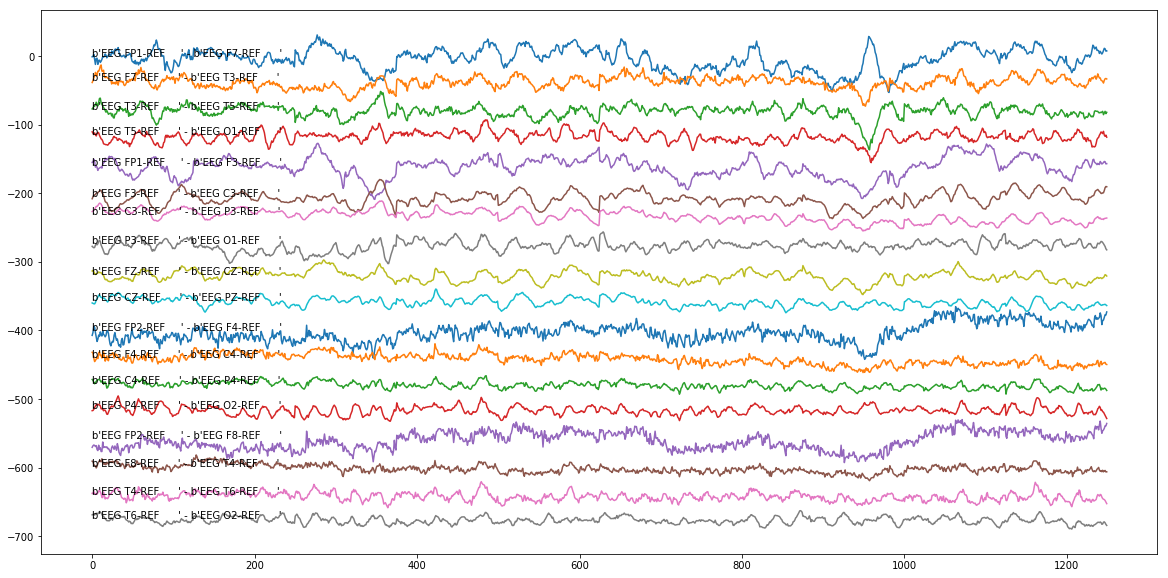

30
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  0
Skipping:  495180
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  521158
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   504652
READ DATA TO INDEX:  504902
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   521158
READ DATA TO INDEX:  521408
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   537664
READ DATA TO INDEX:  537914
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   554170
READ DATA TO INDEX:  554420
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   570676
READ DATA TO INDEX:  570926
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   587182
READ DATA TO INDEX:  587432
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   603688
READ DATA TO INDEX:  603938
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   620194
READ DATA TO INDEX:  620444
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   636700
READ DATA TO

READ DATA TO INDEX:  526408
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   542664
READ DATA TO INDEX:  542914
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   559170
READ DATA TO INDEX:  559420
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   575676
READ DATA TO INDEX:  575926
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   592182
READ DATA TO INDEX:  592432
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   608688
READ DATA TO INDEX:  608938
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   625194
READ DATA TO INDEX:  625444
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   641700
READ DATA TO INDEX:  641950
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   658206
READ DATA TO INDEX:  658456
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  5500
Skipping:  495180
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  526658
I VALUE RIGHT NOW IS:  0
Getting DATA FROM 

Skipping:  495180
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  534158
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   517652
READ DATA TO INDEX:  517902
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   534158
READ DATA TO INDEX:  534408
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   550664
READ DATA TO INDEX:  550914
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   567170
READ DATA TO INDEX:  567420
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   583676
READ DATA TO INDEX:  583926
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   600182
READ DATA TO INDEX:  600432
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   616688
READ DATA TO INDEX:  616938
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   633194
READ DATA TO INDEX:  633444
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   649700
READ DATA TO INDEX:  649950
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   666206
READ DATA TO INDEX: 

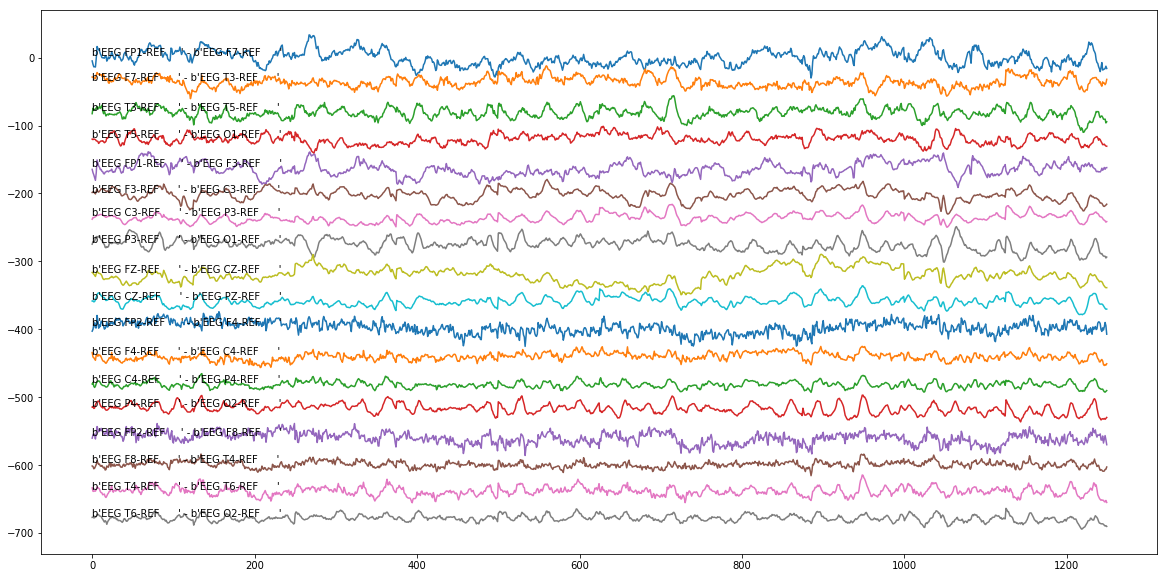

In [ ]:
keepPlotting = 1
while keepPlotting != -1:
    keepPlotting = input()
    plotStart = int(keepPlotting)
    plotEnd = 10
    plt.figure(figsize=(20,10))
    plotEDF(predictEDF1,longBipolarMontage,plotStart,plotEnd,1,False)

0
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  0
Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  25978
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   9472
READ DATA TO INDEX:  9722
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   25978
READ DATA TO INDEX:  26228
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   42484
READ DATA TO INDEX:  42734
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   58990
READ DATA TO INDEX:  59240
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   75496
READ DATA TO INDEX:  75746
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   92002
READ DATA TO INDEX:  92252
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   108508
READ DATA TO INDEX:  108758
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   125014
READ DATA TO INDEX:  125264
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   141520
READ DATA TO INDEX:  141770
I VAL

READ DATA TO INDEX:  128764
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   145020
READ DATA TO INDEX:  145270
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   161526
READ DATA TO INDEX:  161776
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  4000
Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordByteLength*i
Read INDEX:  29978
I VALUE RIGHT NOW IS:  0
Getting DATA FROM INDEX:   13472
READ DATA TO INDEX:  13722
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   29978
READ DATA TO INDEX:  30228
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   46484
READ DATA TO INDEX:  46734
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   62990
READ DATA TO INDEX:  63240
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   79496
READ DATA TO INDEX:  79746
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   96002
READ DATA TO INDEX:  96252
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   112508
RE

READ DATA TO INDEX:  22722
I VALUE RIGHT NOW IS:  1
Getting DATA FROM INDEX:   38978
READ DATA TO INDEX:  39228
I VALUE RIGHT NOW IS:  2
Getting DATA FROM INDEX:   55484
READ DATA TO INDEX:  55734
I VALUE RIGHT NOW IS:  3
Getting DATA FROM INDEX:   71990
READ DATA TO INDEX:  72240
I VALUE RIGHT NOW IS:  4
Getting DATA FROM INDEX:   88496
READ DATA TO INDEX:  88746
I VALUE RIGHT NOW IS:  5
Getting DATA FROM INDEX:   105002
READ DATA TO INDEX:  105252
I VALUE RIGHT NOW IS:  6
Getting DATA FROM INDEX:   121508
READ DATA TO INDEX:  121758
I VALUE RIGHT NOW IS:  7
Getting DATA FROM INDEX:   138014
READ DATA TO INDEX:  138264
I VALUE RIGHT NOW IS:  8
Getting DATA FROM INDEX:   154520
READ DATA TO INDEX:  154770
I VALUE RIGHT NOW IS:  9
Getting DATA FROM INDEX:   171026
READ DATA TO INDEX:  171276
IN CHANNEL DATA FUNCTION
Channel Sample Rate:  250
Sample Durations:  1.0
Channel Index:  13500
Skipping:  0
Record Byte Length:  16506
headerLength+numSkipRecordBytes + self.channelIndex + recordBy

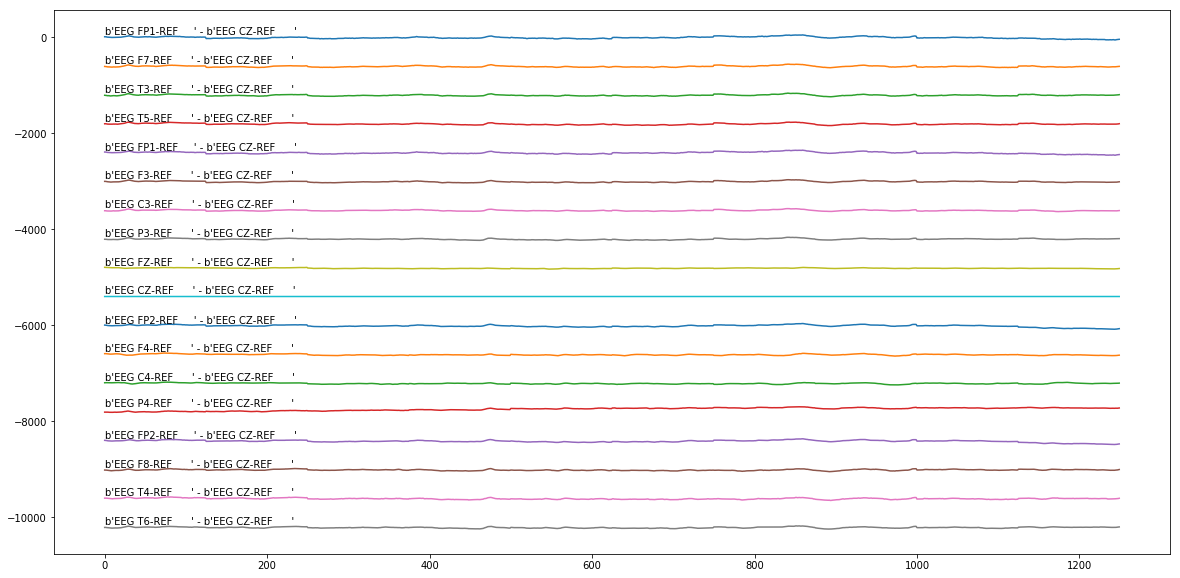

KeyboardInterrupt: 

In [111]:
keepPlotting = 1
while keepPlotting != -1:
    keepPlotting = input()
    plotStart = int(keepPlotting)
    plotEnd = 10
    plt.figure(figsize=(20,10))
    plotEDF(trainingEDF1,czRefMontage,plotStart,plotEnd,1,False)

In [523]:
'''
Signal Processing Functions
'''

def getChangeArray(inputArray):
    newArray =[]
    for i in range(len(inputArray)):
        if i==0:
            pass
        newArray.append(inputArray[i]-inputArray[i-1])
    return newArray

def movingAverage(inputArray,avgNum):
    newArray = []
    for i in range(len(inputArray)):
        if i<avgNum:
            pass
        newArray.append(np.average(inputArray[i-(avgNum):i]))
    return newArray

def returnVariation(eegData,width,sampleRate):
    #Looks for greatest change over the specified width in the signal
    #width is samples to 
    v1 = eegData[0]
    totalChange = 0 
    maxChange = 0
    maxIndex = 0
    dataLength = len(eegData)
    for i in range(dataLength-width):
        currentChange = 0
        for j in range(width-1):
            currentChange += eegData[j+i]-eegData[j+i+1]
             
        if abs(currentChange) > abs(maxChange):
            maxChange = currentChange
            maxIndex = i
        #print(currentChange)
        currentChange = 0
        
    msTime = maxIndex/sampleRate
    #print("Max Change: ",maxChange," Max Index: ",maxIndex," Max Time: ",msTime)
    return [maxChange,maxIndex,msTime]

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff,btype='high', analog = False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order = 5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def range_filter(data, low, high, fs, order = 5):
    dataLow = butter_lowpass_filter(data,high,fs,order)
    dataReturn = butter_highpass_filter(dataLow,low,fs,order)
    return dataReturn
    

def zeroAverage1(data):
    average = np.mean(np.absolute(data))
    returnData = []
    for x in data:
        returnData.append(((x-average)/average)**2)
    return returnData

def normalizeSignal(data):
    maxValue = max(data)
    minValue = min(data)
    valueRange = maxValue-minValue
    returnArray = []
    for x in data:
        returnArray.append(x/valueRange)
    return returnArray
        

In [426]:
def lookForPossibleChannelSpikes(edfObject,montageArray,stepSize,searchSize,ampThreshold,ptpThreshold,durationToCheck,filterTag=False,lowFilter=1,highFilter=40,ampThresholdConstant = True):
    '''
    data should already be scaled 
    stepSize: in mSec
    searchSize: in seconds
    ampThreshold: ratio of max to average or if ampThresholdConstant set to true then this is a uV threshold
    returns: Dictionary {MontageChannelIndex:[spikeIndices]}
    '''
    
    edfDataDictionary = edfObject.dataDictionary(0,durationToCheck)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    possibleSpikeDictionary = {}
    for i,channel in enumerate(montageArray):
        channel1Index = channel[0]
        channel2Index = channel[1]
        channel1Label = dataDictionaryKeys[channel1Index]
        channel2Label = dataDictionaryKeys[channel2Index]
        channel1 = edfDataDictionary[channel1Label]
        channel2= edfDataDictionary[channel2Label]
        
        channel1DigMax = channel1['digMax']
        channel1PhysMax = channel1['physMax']
        channel2DigMax = channel2['digMax']
        channel2PhysMax = channel2['physMax']
        sampleRate = channel1['sampleRate']
        
        channel1ScaleFactor = channel1PhysMax/channel1DigMax
        channel2ScaleFactor = channel2PhysMax/channel2DigMax
        
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        
        channelData = input1Data - input2Data 
        
        if filterTag == True:
            channelData = range_filter(channelData, lowFilter, highFilter, sampleRate, order = 5)
        
        sampleSearchSize = searchSize * sampleRate  #Size to search in each iteration
        stepSampleSize = int((stepSize/1000)*sampleRate)  #samples to move during each step
        totalSamples = durationToCheck * sampleRate  #Total Number of samples to check in data file
        numberOfSteps = int(totalSamples/stepSampleSize) #Total number of steps to take
        
        #print("SampleSearchSize: ",sampleSearchSize,"\nstepSampleSize: ",stepSampleSize,
        #    "\ntotalSamples: ",totalSamples,"\nnumberOfSteps: ",numberOfSteps)
    
        possibleSpikeArray = []
        
        for x in range(numberOfSteps):
            startIndex = x*stepSampleSize
            endIndex = (x*stepSampleSize)+sampleSearchSize
            segmentToCheck = channelData[startIndex:endIndex]
            segmentMax = np.amax(np.absolute(segmentToCheck))
            segmentPTP = np.ptp(segmentToCheck)
            segmentAverage = abs(np.average(segmentToCheck))
            freqs, pxx = scipy.signal.periodogram(segmentToCheck, sampleRate)
            if ampThresholdConstant == True:
                amplitudeThreshold = ampThreshold
            else:
                amplitudeThreshold = segmentAverage * ampThreshold
            ptpThreshold = segmentAverage * ptpThreshold
            #print("AmplitudeThreshold: ",amplitudeThreshold,"\nSegment Max: ",segmentMax,"\nSegmentPTP: ",segmentPTP,
            #     "\nSegmentAverage: ",segmentAverage, "StartIndex: ",startIndex)
            #print("StartIndex: ",startIndex,"\nEndIndex: ",endIndex,"\nSegmentAverage: ",segmentAverage,
            #    "/nsegmentMax: ",segmentMax,"\nAmplitudeThreshold: ", amplitudeThreshold,"\nptpThreshold: ",ptpThreshold)
            if segmentMax > amplitudeThreshold and segmentPTP > amplitudeThreshold:
                try:
                    possibleSegmentIndex = list(segmentToCheck).index(segmentMax)
                except:
                    possibleSegmentIndex = list(segmentToCheck).index(0-segmentMax)
                    
                channelSpikeIndex = startIndex + possibleSegmentIndex
                if channelSpikeIndex not in possibleSpikeArray: 
                    possibleSpikeArray.append(channelSpikeIndex)
        
        possibleSpikeDictionary[i] = possibleSpikeArray
    return possibleSpikeDictionary
                    
                    
    


def checkQuadrants(indexDict,adjacencyArray,edfObject,latencyAllowed):
    '''
    Ths function makes sure that a possible spike exists at the same time in more than one channel.
    adjacencyArray: list of lists containing channel indices in quadrant
    indexDict: {channelNumber:[spikeCandidates]}
    latencyAllowed: latency in mSec allowed, distance between spikes in different channels
    
    returns: List of Lists containing possible spikes indices in each quadrant
    '''
    spikeCandidatesFinal = []
    sampleRate = edfObject.getSampleRate()
    spikeDistanceAllowed = latencyAllowed/sampleRate
    for quadrant in adjacencyArray:
        quadrantCandidates = []
        for channelIndex in quadrant: 
            for spikeIndex in indexDict[channelIndex]:
                quadrantCandidates.append(spikeIndex)
        #print("Quadrant1:",len(quadrantCandidates))
        isolatesRemoved = removeIsolatedSpikes(sampleRate,quadrantCandidates,latencyAllowed)
        spikeCandidatesFinal.append(isolatesRemoved)
    return spikeCandidatesFinal
                
                

def removeIsolatedSpikes(sampleRate,quadrantSpikesIn,latencyAllowedIn):
    '''
    Run this only in checkQuadrants!
    indexArray: Array of indices of possible spikes in a quadrant
    sampleRate: sampleRate of data
    latencyAllowed: distance between possible spikes in msec
    
    To do: Add adjacency coefficient
    '''
    returnList = []
    #print("LEN in",len(quadrantSpikesIn))
    quadrantSpikesIn.sort() 
    numberOfSpikes = len(quadrantSpikesIn)
    indexDistanceLimit = (latencyAllowedIn/1000) * sampleRate
    for i in range(numberOfSpikes-2):
        if i ==0:
            pass
        else:
            distanceLeft = abs(quadrantSpikesIn[i]-quadrantSpikesIn[i+1])
            distanceRight = abs(quadrantSpikesIn[i]-quadrantSpikesIn[i-1])
            if distanceLeft > indexDistanceLimit and distanceRight > indexDistanceLimit:
                pass
                #print("Removed, no adjaceny")
            else:
                returnList.append(quadrantSpikesIn[i])
    return returnList
            

def removeCloseSpikes(indexArray,edfObject,minDistanceBetweenSpikes):
    '''
    indexArray: Array of indices of possible spikes in a quadrant
    sampleRate: sampleRate of data
    latencyAllowed: distance between possible spikes in msec
    '''
    edfSampleRate = edfObject.getSampleRate()
    indexArray.sort()
    latencySamplesAllowed = (minDistanceBetweenSpikes/1000) * edfSampleRate
    returnArray = []
    indexLength = len(indexArray)
    removed = 0
    for i, x in enumerate(indexArray):
        sampleDistance = 1
        if i <= 1:
            returnArray.append(x)
        else:
            returnLength = len(returnArray)
            if (x-returnArray[returnLength-1]) > latencySamplesAllowed:
                returnArray.append(x)
            else:
                removed+=1
    #print("Removed: ",removed)
    return returnArray

In [427]:
#lookForPossibleChannelSpikes(edfObject,montageArray,stepSize,searchSize,ampThreshold,ptpThreshold,durationToCheck,filterTag=False,loFilter=1,highFilter=40,ampThresholdConstant = True)
possibleSpikesPrelim = lookForPossibleChannelSpikes(trainingEDF1,longBipolarMontage,150,1,100,3,120,filterTag=True,lowFilter=1,highFilter=40)
possibleSpikesPrelimPredict = lookForPossibleChannelSpikes(predictEDF1,longBipolarMontage,150,1,100,3,120,filterTag=True,lowFilter=1,highFilter=40)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars


In [223]:
#PREDICT
print(possibleSpikesPrelim.keys())
for x in range(16):
    #print(len(possibleSpikesPrelim[x]))
    possibleSpikesPrelim[x]=removeCloseSpikes(possibleSpikesPrelim[x],trainingEDF1,300)
    #print("prelim elim: ",len(possibleSpikesPrelim[x]))
    
finalCandidatesB = checkQuadrants(possibleSpikesPrelim,adjacentElectrodeArray,trainingEDF1,20)
finalCandidates = []
for x in finalCandidatesB:
    #print(len(x))
    finalCandidates.append(removeCloseSpikes(x,trainingEDF1,300))
    
for y in finalCandidates:
    print("FINAL LEN: ",len(y))
    print(y)


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
FINAL LEN:  21
[38, 3788, 3874, 3988, 6610, 6708, 7957, 12041, 12217, 14726, 14975, 16098, 16235, 18794, 20225, 20327, 20444, 24371, 24516, 28516, 28658]
FINAL LEN:  25
[3838, 3845, 3985, 4147, 7945, 8074, 12126, 12273, 14829, 15079, 16195, 16324, 20079, 20265, 20410, 20531, 22579, 22832, 24445, 24574, 28082, 28332, 28550, 28661, 28788]
FINAL LEN:  19
[355, 355, 603, 2110, 5836, 5993, 8363, 8613, 8712, 10363, 14141, 14260, 16856, 17116, 18616, 22374, 22597, 24870, 25119]
FINAL LEN:  24
[1780, 1908, 5934, 6070, 8024, 10039, 10167, 14079, 14216, 14318, 16159, 16305, 16723, 18297, 18425, 22358, 22449, 24457, 24597, 24725, 24975, 26555, 26683, 29366]


In [428]:
#TRAIN
print(possibleSpikesPrelimPredict.keys())
for x in range(16):
    #print(len(possibleSpikesPrelim[x]))
    possibleSpikesPrelimPredict[x]=removeCloseSpikes(possibleSpikesPrelimPredict[x],predictEDF1,300)
    #print("prelim elim: ",len(possibleSpikesPrelim[x]))
    
finalCandidatesBPredict = checkQuadrants(possibleSpikesPrelimPredict,adjacentElectrodeArray,predictEDF1,20)
finalCandidatesPredict = []
for x in finalCandidatesBPredict:
    #print(len(x))
    finalCandidatesPredict.append(removeCloseSpikes(x,trainingEDF1,300))
    
for y in finalCandidatesPredict:
    print("FINAL LEN: ",len(y))
    print(y)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
FINAL LEN:  54
[901, 901, 1009, 1182, 1489, 1598, 1748, 4027, 4119, 4670, 6206, 7003, 7106, 7197, 7322, 7787, 7893, 8138, 10016, 10232, 12097, 13202, 13305, 13462, 13783, 13917, 14170, 14809, 15133, 16210, 16334, 17440, 18650, 19293, 19478, 19603, 19744, 20957, 21280, 21485, 22331, 22431, 22539, 23331, 23436, 25501, 25604, 25744, 26077, 26848, 27104, 27683, 28527, 28638]
FINAL LEN:  58
[5, 284, 977, 1096, 1282, 1564, 2079, 2335, 2591, 4013, 4127, 4252, 4895, 6025, 6175, 6281, 6431, 7095, 7214, 7304, 7434, 7968, 8077, 10257, 10382, 12172, 13213, 13331, 13444, 13585, 13858, 13965, 14479, 14991, 16393, 16513, 17110, 19443, 19561, 19738, 20005, 20370, 20882, 21032, 21174, 22519, 22646, 24872, 25562, 25681, 25890, 26259, 26667, 26773, 26923, 28658, 28779, 29696]
FINAL LEN:  71
[41, 230, 452, 998, 1319, 1577, 2431, 2533, 2674, 5499, 5614, 5770, 5932, 6633, 6889, 7145, 7401, 8525, 8728, 9449, 10217, 11614, 11753, 11830,



QUADRANT   ______  [38, 3788, 3874, 3988, 6610, 6708, 7957, 12041, 12217, 14726, 14975, 16098, 16235, 18794, 20225, 20327, 20444, 24371, 24516, 28516, 28658]
Spike Index:  38


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


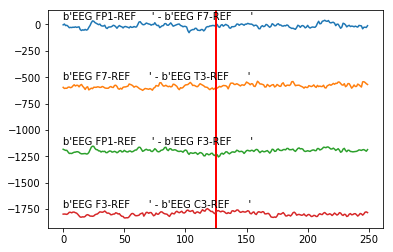

Spike Index:  3788


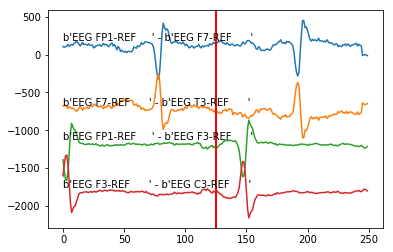

Spike Index:  3874


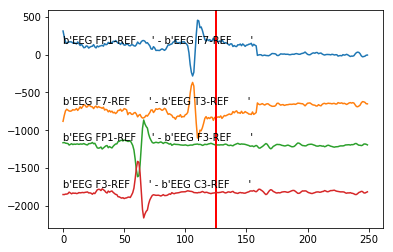

Spike Index:  3988


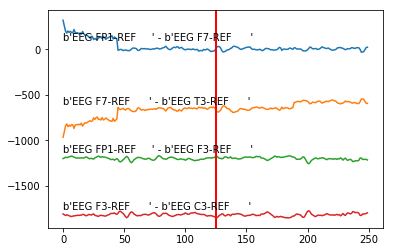

Spike Index:  6610


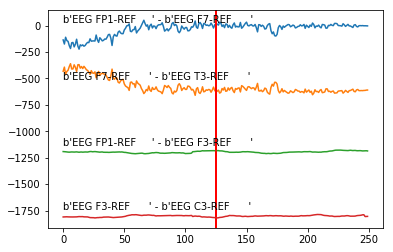

Spike Index:  6708


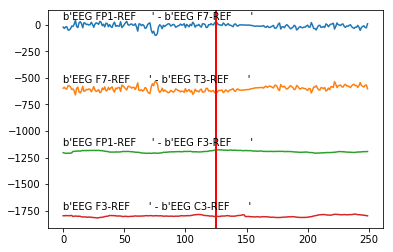

Spike Index:  7957


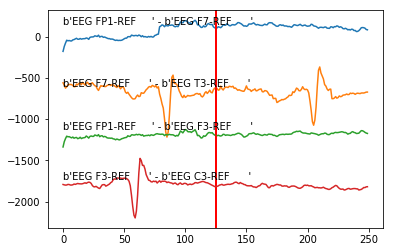

Spike Index:  12041


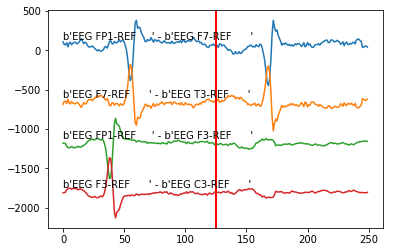

Spike Index:  12217


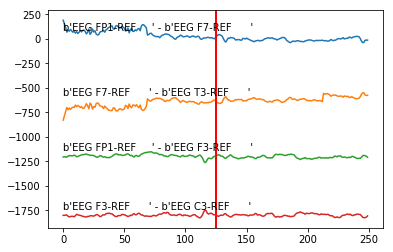

Spike Index:  14726


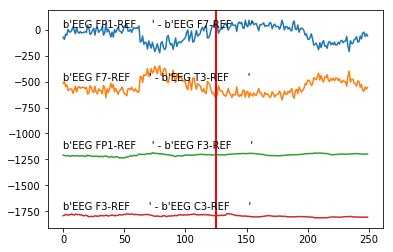

Spike Index:  14975


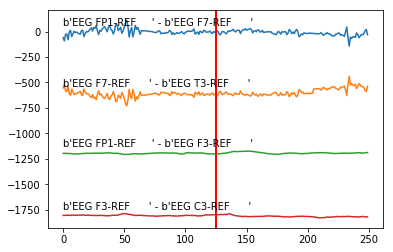

Spike Index:  16098


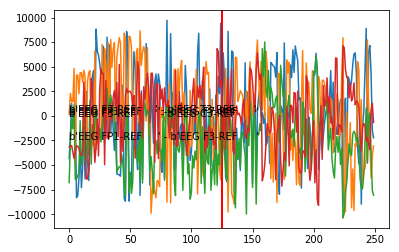

Spike Index:  16235


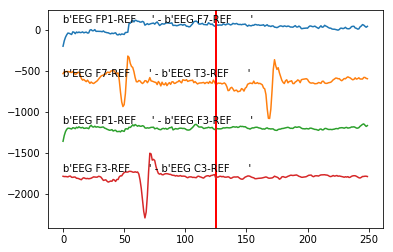

Spike Index:  18794


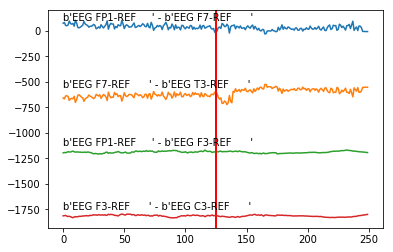

Spike Index:  20225


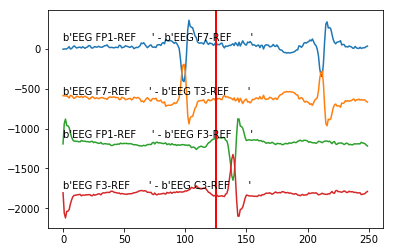

Spike Index:  20327


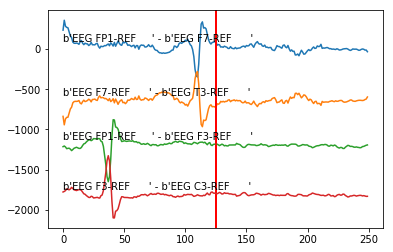

Spike Index:  20444


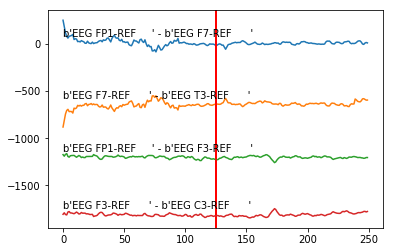

Spike Index:  24371


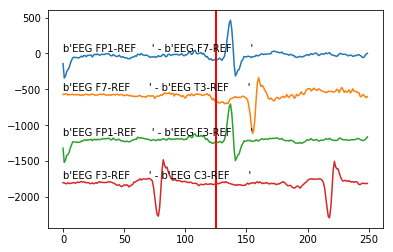

Spike Index:  24516


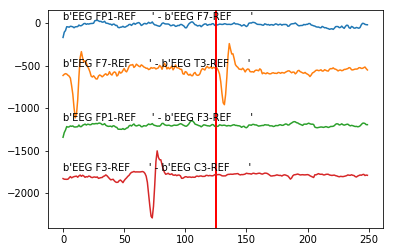

Spike Index:  28516


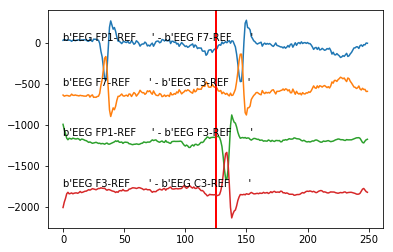



QUADRANT   ______  [3838, 3845, 3985, 4147, 7945, 8074, 12126, 12273, 14829, 15079, 16195, 16324, 20079, 20265, 20410, 20531, 22579, 22832, 24445, 24574, 28082, 28332, 28550, 28661, 28788]
Spike Index:  3838


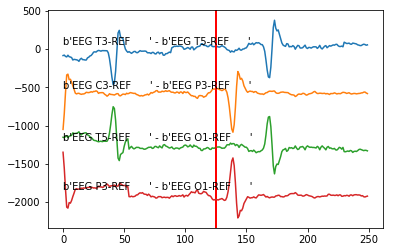

Spike Index:  3845


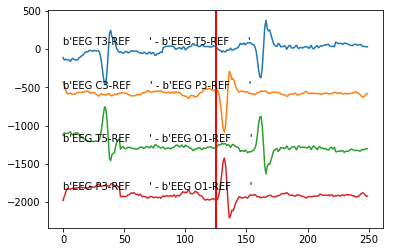

Spike Index:  3985


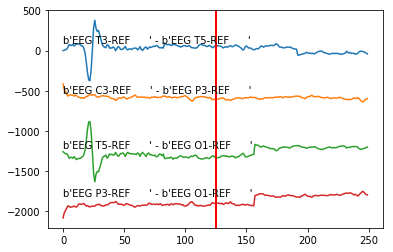

Spike Index:  4147


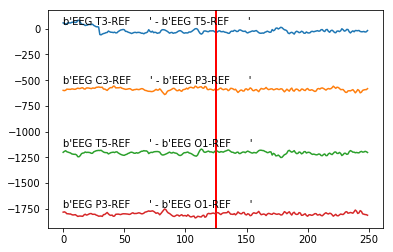

Spike Index:  7945


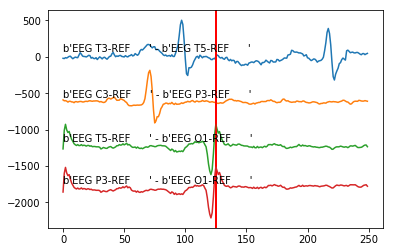

Spike Index:  8074


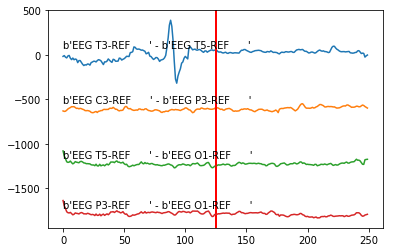

Spike Index:  12126


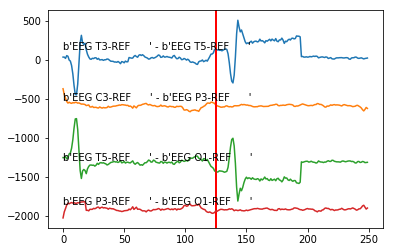

Spike Index:  12273


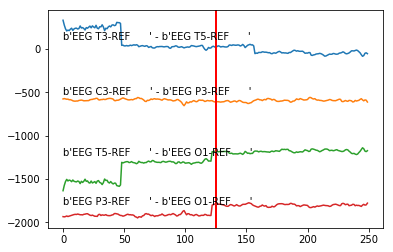

Spike Index:  14829


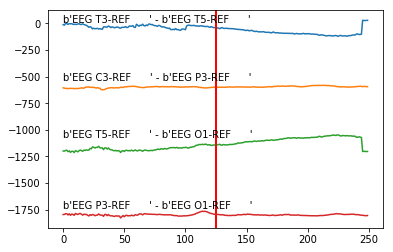

Spike Index:  15079


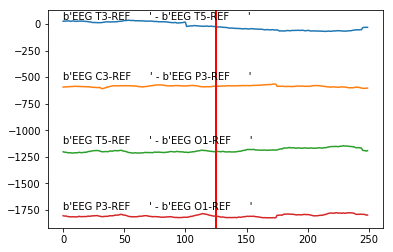

Spike Index:  16195


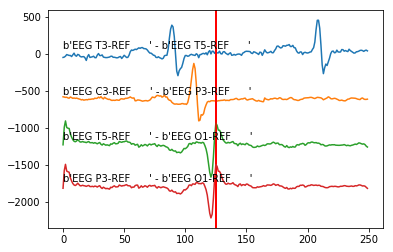

Spike Index:  16324


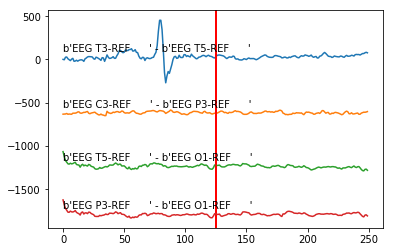

Spike Index:  20079


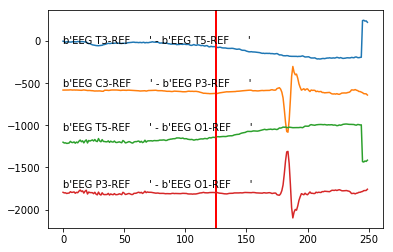

Spike Index:  20265


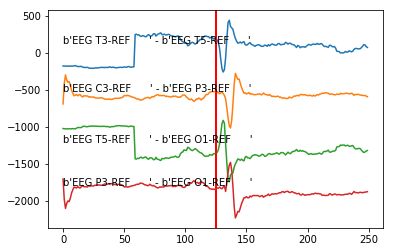

Spike Index:  20410


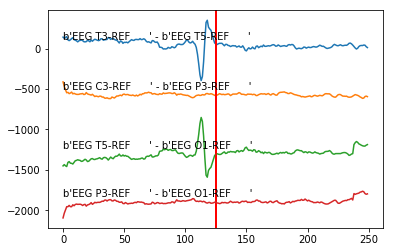

Spike Index:  20531


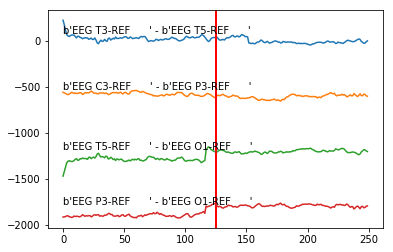

Spike Index:  22579


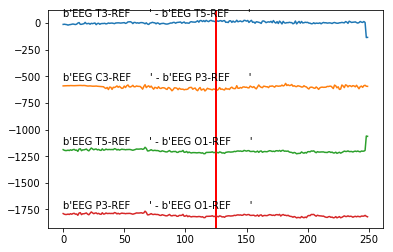

Spike Index:  22832


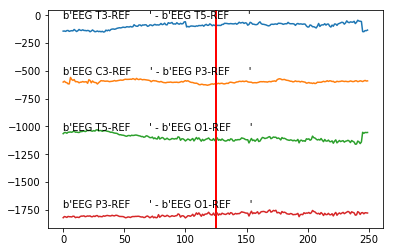

Spike Index:  24445


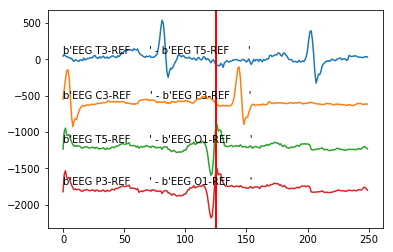

Spike Index:  24574


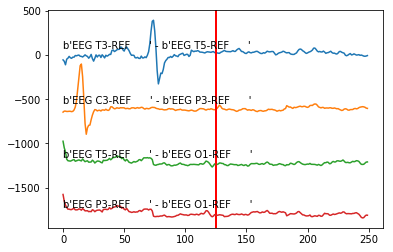



QUADRANT   ______  [355, 355, 603, 2110, 5836, 5993, 8363, 8613, 8712, 10363, 14141, 14260, 16856, 17116, 18616, 22374, 22597, 24870, 25119]
Spike Index:  355


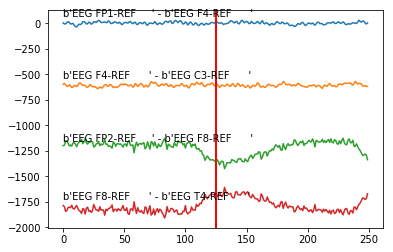

Spike Index:  355


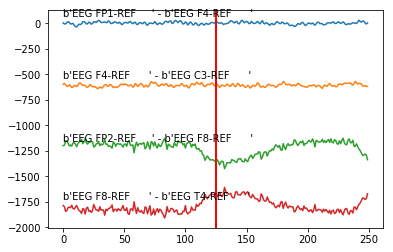

Spike Index:  603


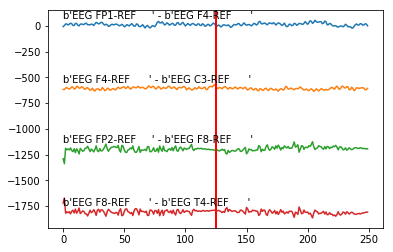

Spike Index:  2110


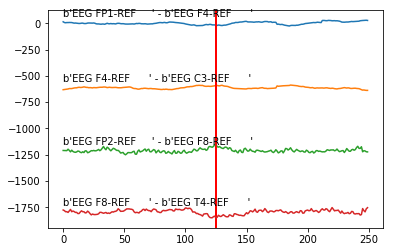

Spike Index:  5836


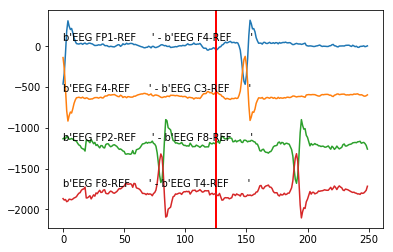

Spike Index:  5993


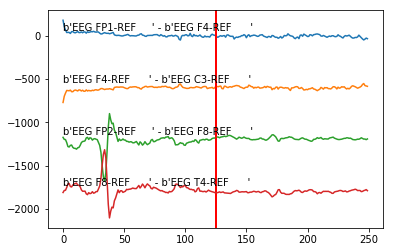

Spike Index:  8363


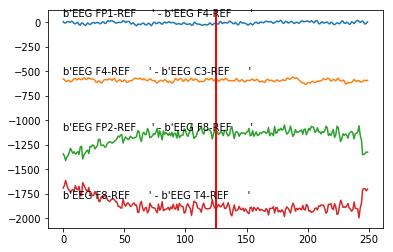

Spike Index:  8613


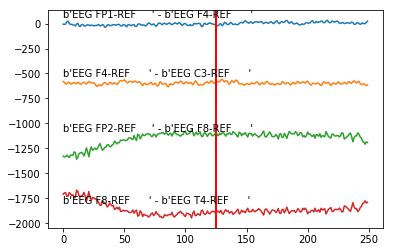

Spike Index:  8712


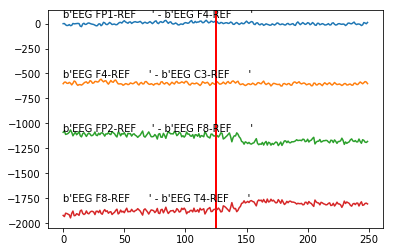

Spike Index:  10363


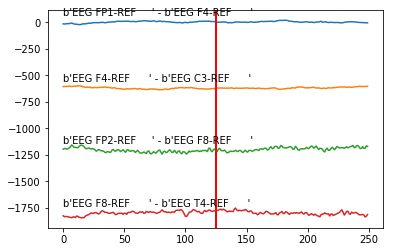

Spike Index:  14141


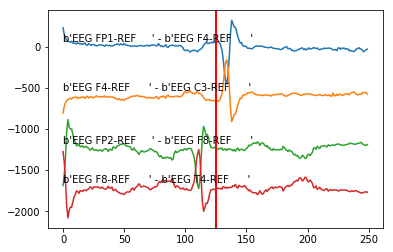

Spike Index:  14260


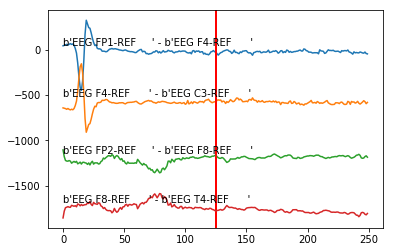

Spike Index:  16856


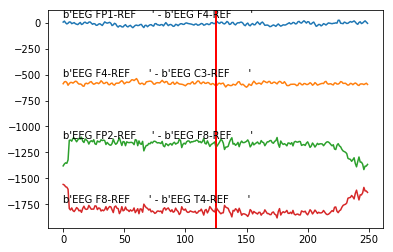

Spike Index:  17116


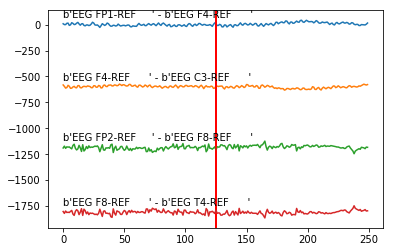

Spike Index:  18616


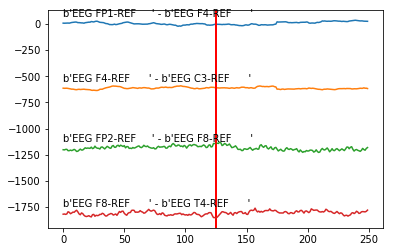

Spike Index:  22374


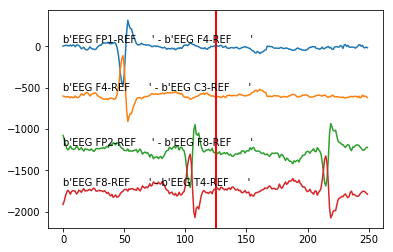

Spike Index:  22597


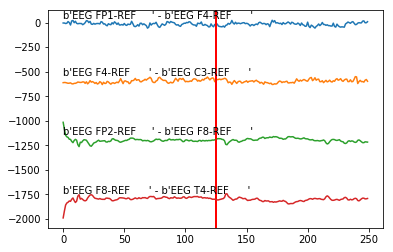

Spike Index:  24870


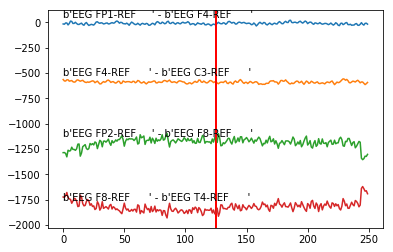

Spike Index:  25119


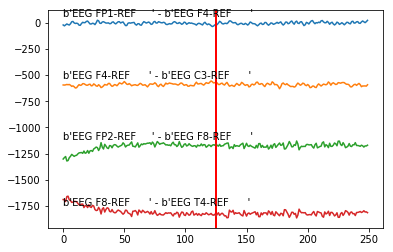



QUADRANT   ______  [1780, 1908, 5934, 6070, 8024, 10039, 10167, 14079, 14216, 14318, 16159, 16305, 16723, 18297, 18425, 22358, 22449, 24457, 24597, 24725, 24975, 26555, 26683, 29366]
Spike Index:  1780


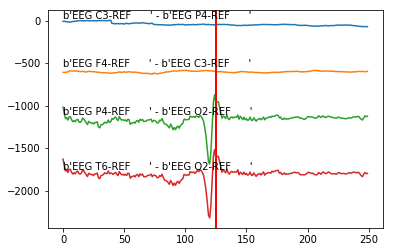

Spike Index:  1908


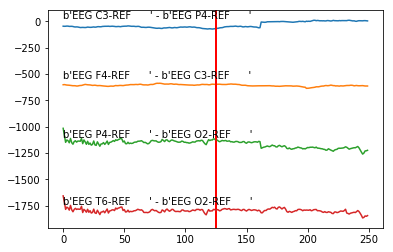

Spike Index:  5934


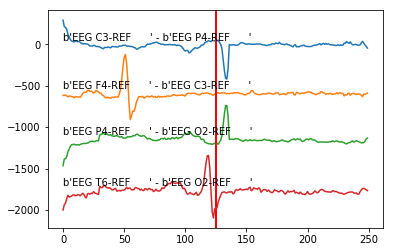

Spike Index:  6070


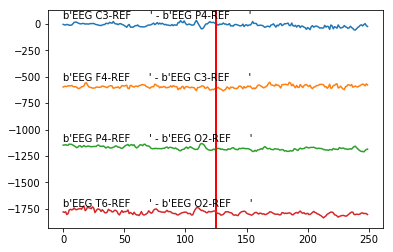

Spike Index:  8024


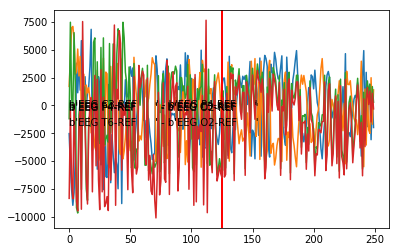

Spike Index:  10039


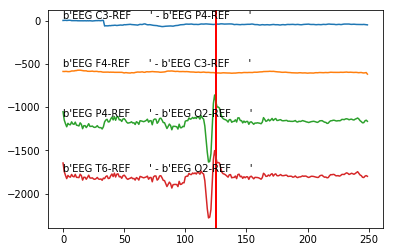

Spike Index:  10167


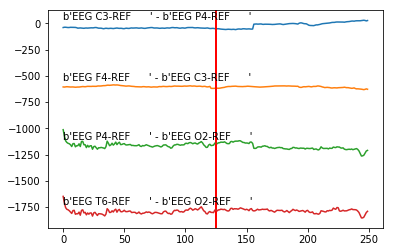

Spike Index:  14079


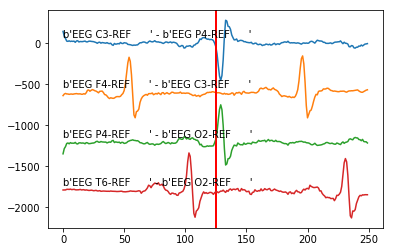

Spike Index:  14216


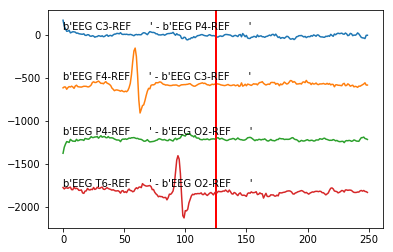

Spike Index:  14318


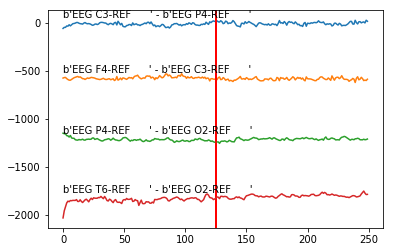

Spike Index:  16159


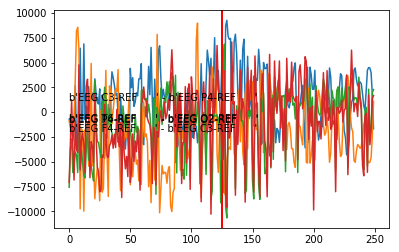

Spike Index:  16305


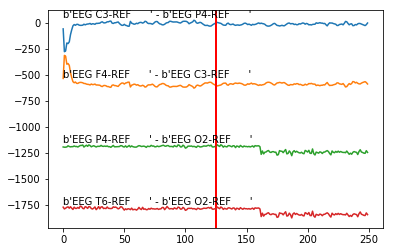

Spike Index:  16723


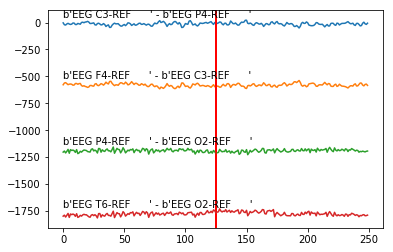

Spike Index:  18297


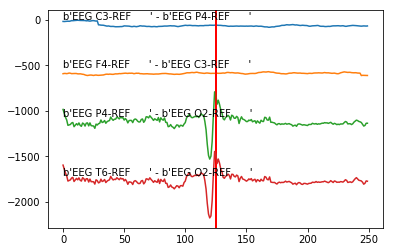

Spike Index:  18425


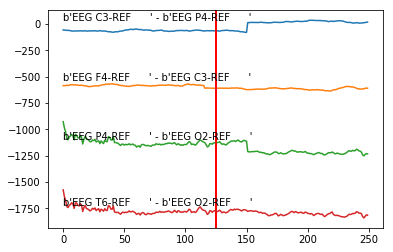

Spike Index:  22358


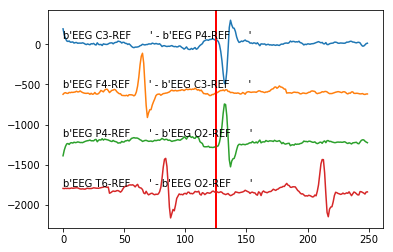

Spike Index:  22449


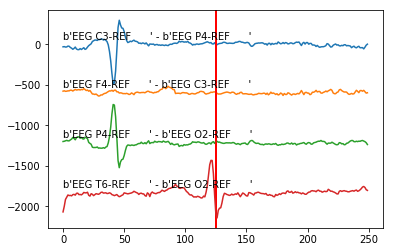

Spike Index:  24457


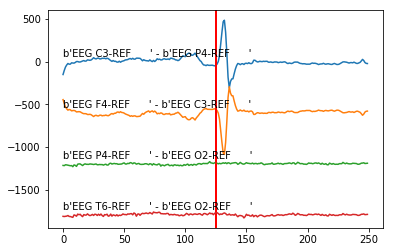

Spike Index:  24597


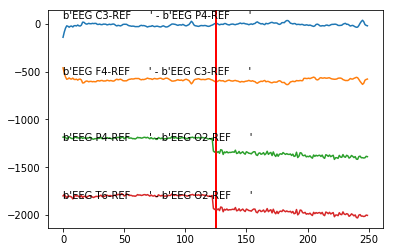

Spike Index:  24725


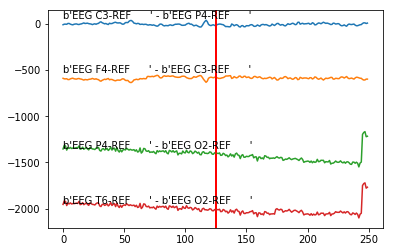

In [225]:
#plotQuadrantSpike(edfObject,quadrantArray,montageArray,quadrantToPlot,indexToPlot,timeSpan)

for i,quadrant in enumerate(finalCandidates):
    print("\n\nQUADRANT   ______ ",quadrant)
    for spikeIndex in quadrant[0:20]:
        print("Spike Index: ",spikeIndex)
        plotQuadrantSpike(trainingEDF1,adjacentElectrodeArray,longBipolarMontage,i,spikeIndex,1) 

In [256]:
def checkInput():
    a = input()
    a = int(a)
    if int(a)==0 or int(a)==1:
        return int(a)
    checkInput()
    
def markQuadrants(finalCandidatesIn,edfIn):
    '''
    takes 
    Returns: quadrantDict = {quadrant:[index,trueSpike?]}
    '''
    returnDict = {}
    for i,quadrant in enumerate(finalCandidatesIn):
        spikeIndexArray = []
        print("\n\nQUADRANT   ______ ",quadrant)
        for spikeIndex in quadrant:
            print("Spike Index: ",spikeIndex)
            plotQuadrantSpike(edfIn,adjacentElectrodeArray,longBipolarMontage,i,spikeIndex,1) 
            trueSpike = checkInput()
            spikeIndexArray.append([spikeIndex,trueSpike])
            print("Spike? ",trueSpike)
            print("Spike Index Array:", spikeIndexArray)
        returnDict[i] = spikeIndexArray
        print("RETURN DICT------------------",returnDict)
    return returnDict
            
#markQuadrants()
            



QUADRANT   ______  [38, 3788, 3874, 3988, 6610, 6708, 7957, 12041, 12217, 14726, 14975, 16098, 16235, 18794, 20225, 20327, 20444, 24371, 24516, 28516, 28658]
Spike Index:  38


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


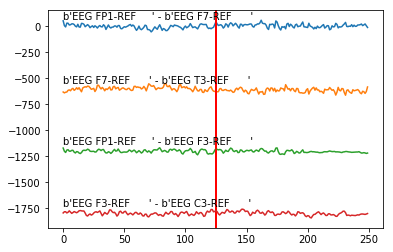

0
Spike?  0
Spike Index Array: [[38, 0]]
Spike Index:  3788


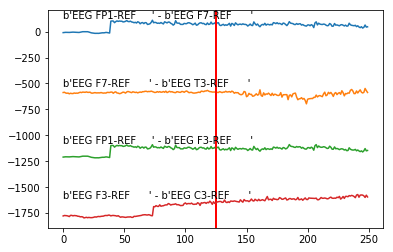

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0]]
Spike Index:  3874


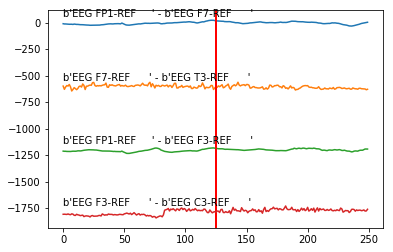

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0]]
Spike Index:  3988


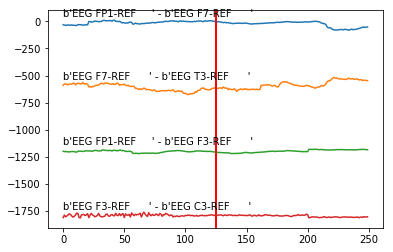

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0]]
Spike Index:  6610


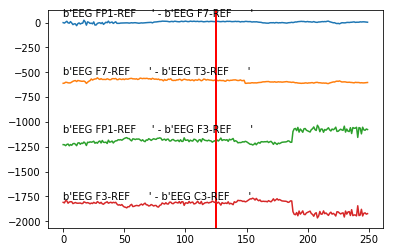

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0]]
Spike Index:  6708


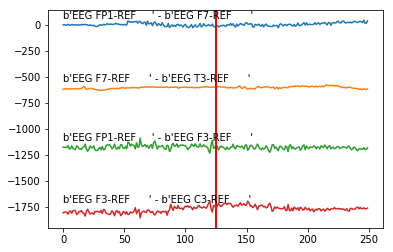

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0]]
Spike Index:  7957


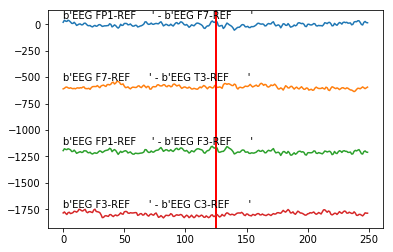

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0]]
Spike Index:  12041


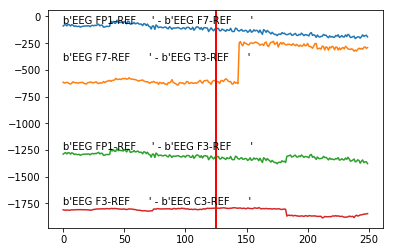

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0]]
Spike Index:  12217


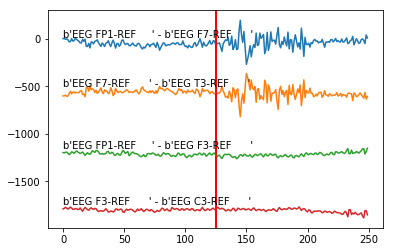

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0]]
Spike Index:  14726


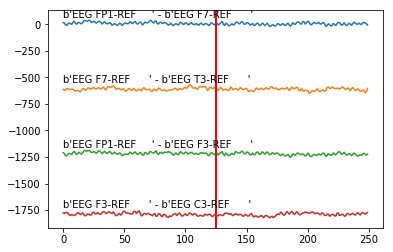

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0]]
Spike Index:  14975


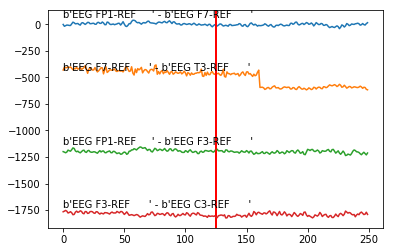

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0]]
Spike Index:  16098


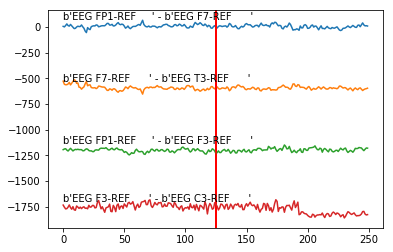

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0]]
Spike Index:  16235


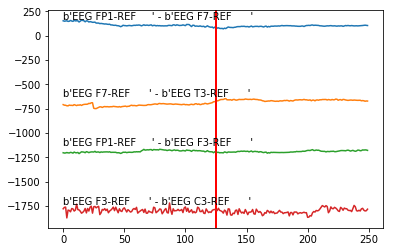

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0]]
Spike Index:  18794


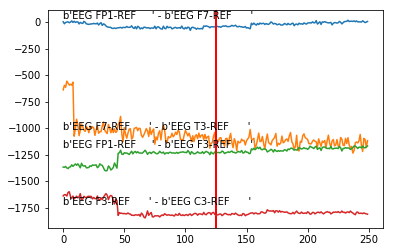

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0]]
Spike Index:  20225


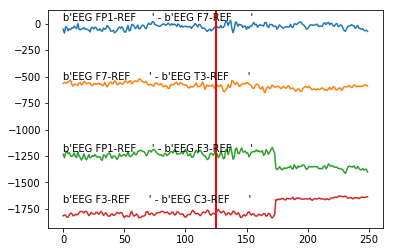

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0]]
Spike Index:  20327


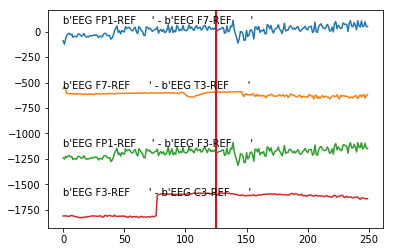

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0]]
Spike Index:  20444


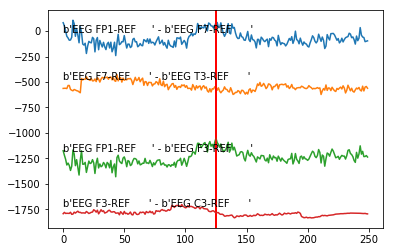

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0], [20444, 0]]
Spike Index:  24371


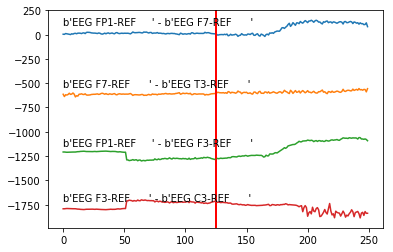

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0], [20444, 0], [24371, 0]]
Spike Index:  24516


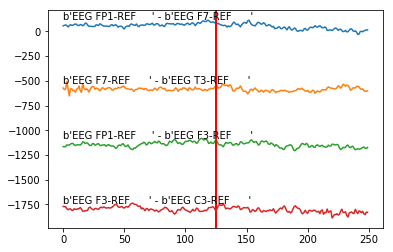

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0], [20444, 0], [24371, 0], [24516, 0]]
Spike Index:  28516


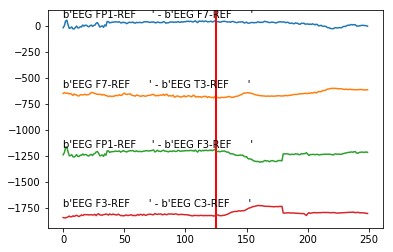

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0], [20444, 0], [24371, 0], [24516, 0], [28516, 0]]
Spike Index:  28658


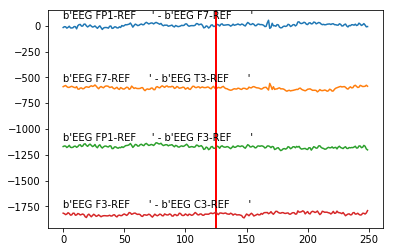

0
Spike?  0
Spike Index Array: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0], [20444, 0], [24371, 0], [24516, 0], [28516, 0], [28658, 0]]
RETURN DICT------------------ {0: [[38, 0], [3788, 0], [3874, 0], [3988, 0], [6610, 0], [6708, 0], [7957, 0], [12041, 0], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 0], [18794, 0], [20225, 0], [20327, 0], [20444, 0], [24371, 0], [24516, 0], [28516, 0], [28658, 0]]}


QUADRANT   ______  [3838, 3845, 3985, 4147, 7945, 8074, 12126, 12273, 14829, 15079, 16195, 16324, 20079, 20265, 20410, 20531, 22579, 22832, 24445, 24574, 28082, 28332, 28550, 28661, 28788]
Spike Index:  3838


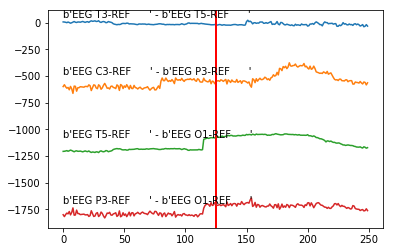

0
Spike?  0
Spike Index Array: [[3838, 0]]
Spike Index:  3845


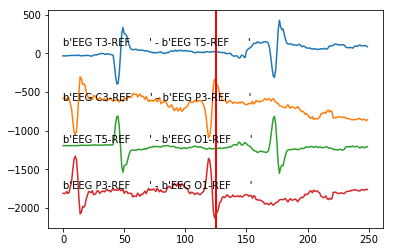

1
Spike?  1
Spike Index Array: [[3838, 0], [3845, 1]]
Spike Index:  3985


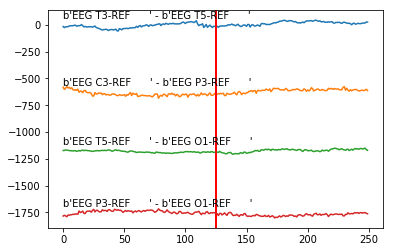

KeyboardInterrupt: 

In [264]:
trainingSetMarkers1 = markQuadrants(finalCandidates,trainingEDF1)



QUADRANT   ______  [901, 901, 1009, 1182, 1489, 1598, 1748, 4027, 4119, 4670, 6206, 7003, 7106, 7197, 7322, 7787, 7893, 8138, 10016, 10232, 12097, 13202, 13305, 13462, 13783, 13917, 14170, 14809, 15133, 16210, 16334, 17440, 18650, 19293, 19478, 19603, 19744, 20957, 21280, 21485, 22331, 22431, 22539, 23331, 23436, 25501, 25604, 25744, 26077, 26848, 27104, 27683, 28527, 28638]
Spike Index:  901
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


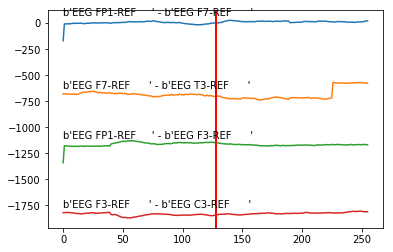

0
Spike?  0
Spike Index Array: [[901, 0]]
Spike Index:  901
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


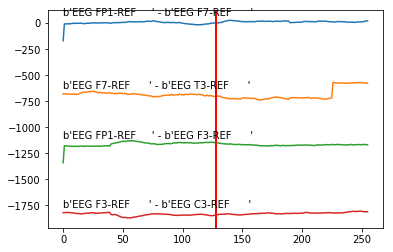

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0]]
Spike Index:  1009
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


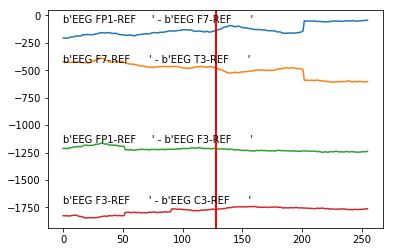

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0]]
Spike Index:  1182
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


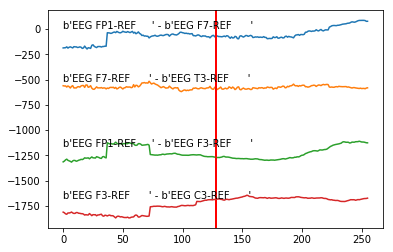

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0]]
Spike Index:  1489
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


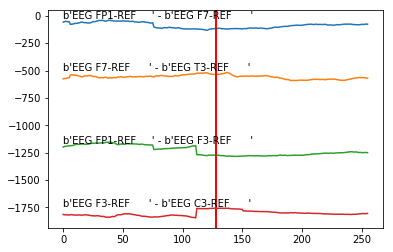

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0], [1489, 0]]
Spike Index:  1598
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


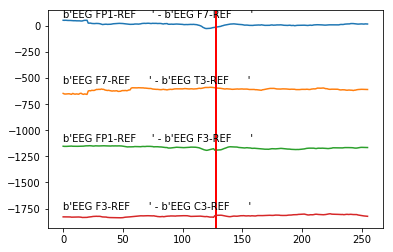

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0], [1489, 0], [1598, 0]]
Spike Index:  1748
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457
Channel2SCALE FACTOR:  0.1673112582781457


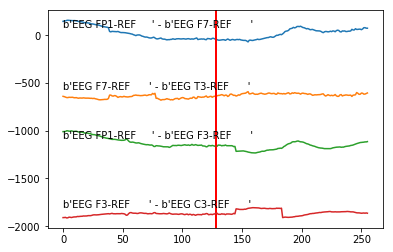

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0], [1489, 0], [1598, 0], [1748, 0]]
Spike Index:  4027
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN F

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

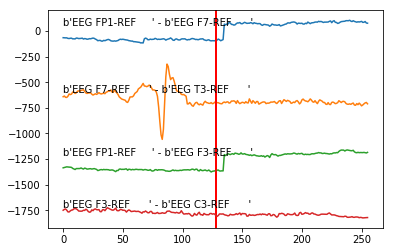

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0], [1489, 0], [1598, 0], [1748, 0], [4027, 0]]
Spike Index:  4119
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

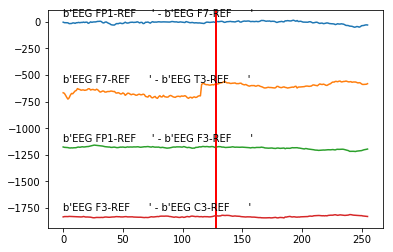

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0], [1489, 0], [1598, 0], [1748, 0], [4027, 0], [4119, 0]]
Spike Index:  4670
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE P

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

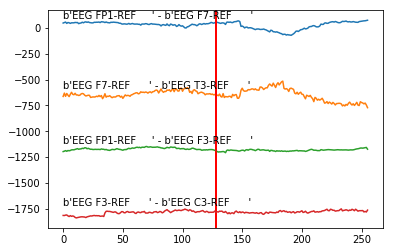

0
Spike?  0
Spike Index Array: [[901, 0], [901, 0], [1009, 0], [1182, 0], [1489, 0], [1598, 0], [1748, 0], [4027, 0], [4119, 0], [4670, 0]]
Spike Index:  6206
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERRO

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
ERROR IN FILE PARSER:  b''
E

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [477]:
predictSetMarkers = markQuadrants(finalCandidatesPredict,predictEDF1)

In [430]:
#print(trainingSetMarkers.keys())
for x in trainingSetMarkers:
    print("X: ",x,"\n",trainingSetMarkers[x])
    
print("\n\n")
for x in predictSetMarkers:
    print("X: ",x,"\n",predictSetMarkers[x])

X:  0 
 [[38, 0], [3788, 1], [3874, 1], [3988, 0], [6610, 0], [6708, 0], [7957, 1], [12041, 1], [12217, 0], [14726, 0], [14975, 0], [16098, 0], [16235, 1], [18794, 0], [20225, 1], [20327, 1], [20444, 0], [24371, 1], [24516, 1], [28516, 1], [28658, 1]]
X:  1 
 [[3838, 1], [3845, 1], [3985, 1], [4147, 0], [7945, 1], [8074, 1], [12126, 1], [12273, 0], [14829, 0], [15079, 0], [16195, 1], [16324, 1], [20079, 1], [20265, 1], [20410, 1], [20531, 0], [22579, 0], [22832, 0], [24445, 1], [24574, 1], [28082, 0], [28332, 1], [28550, 1], [28661, 1], [28788, 0]]
X:  2 
 [[355, 0], [355, 0], [603, 0], [2110, 0], [5836, 1], [5993, 1], [8363, 0], [8613, 0], [8712, 0], [10363, 0], [14141, 1], [14260, 1], [16856, 0], [17116, 0], [18616, 0], [22374, 1], [22597, 0], [24870, 0], [25119, 0]]
X:  3 
 [[1780, 1], [1908, 0], [5934, 1], [6070, 0], [8024, 0], [10039, 1], [10167, 0], [14079, 1], [14216, 1], [14318, 0], [16159, 0], [16305, 0], [16723, 0], [18297, 1], [18425, 0], [22358, 1], [22449, 1], [24457, 0], 

NameError: name 'predictSetMarkers' is not defined

In [389]:
def getAverageAmplitudeChange(dataString,sampleRate):
    return "Not done yet"

def getSlope(dataString,sampleRate):
    dataMax = max(dataString)
    dataMin = min(dataString)
    
    maxIndex = list(dataString).index(dataMax)
    minIndex = list(dataString).index(dataMin)
    #print("Data String: ",dataString/10)
    #print("maxIndex: ",maxIndex)
    #print("Min Index: ",minIndex)
    
    dataAverage = np.average(dataString)
    if maxIndex<minIndex:
        upFound = False
        downFound = False
        i = 1
        while upFound == False:
            deflectionFound = dataString[maxIndex-i-1] > dataString[maxIndex-i]
            #print("Data max>min up: ",dataString[maxIndex-i-1], dataString[maxIndex-i])
            if deflectionFound:
                upwardDuration = i/sampleRate #Duration in mSec
                amplitudeChange = dataMax - dataString[maxIndex - i - 1]
                upwardSlope = amplitudeChange/upwardDuration
                upwardIndex = maxIndex - i
                upFound = True
                i = 1
            else:
                i+=1
        while downFound == False:
            deflectionFound = dataString[maxIndex+i+1] > dataString[maxIndex+i]
            #print("Data max>min down: ",dataString[maxIndex+i+1], dataString[maxIndex+i])
            if deflectionFound:
                downwardDuration = i/sampleRate #Duration in mSec
                amplitudeChange = dataMax - dataString[maxIndex + i + 1]
                downwardSlope = amplitudeChange/downwardDuration
                downwardIndex = maxIndex + i + 1
                downFound = True
                i = 1
            else:
                i+=1
                
    elif minIndex<maxIndex:
        upFound = False
        downFound = False
        i = 1
        while upFound == False:
            if minIndex+i+1 >= sampleRate:
                deflectionFound = True
            else:
                deflectionFound = dataString[minIndex+i+1] < dataString[minIndex+i]
            #print("Data min< max up: ",dataString[minIndex+i+1], dataString[minIndex+i]," i: ",i)
            if deflectionFound:
                upwardDuration = i/sampleRate #Duration in mSec
                amplitudeChange = dataString[minIndex + i] - dataMin
                upwardSlope = amplitudeChange/upwardDuration
                upwardIndex = minIndex + i
                #print("upwardSlope: ",upwardSlope, "index: ",upwardIndex)
                upFound = True
                i = 1
            else:
                i+=1
        while downFound == False:
            deflectionFound = dataString[minIndex-i-1] < dataString[minIndex-i]
            #print("Data min<max down: ",dataString[minIndex-i-1], dataString[minIndex-i])
            if deflectionFound:
                #print("Found a deflection")
                downwardDuration = i/sampleRate #Duration in mSec
                amplitudeChange = dataString[minIndex - i - 1] - dataMin
                downwardSlope = amplitudeChange/downwardDuration
                downwardIndex = minIndex - i - 1
                downFound = True
                i = 1
            else:
                i+=1
                
        
    return [upwardSlope,downwardSlope,downwardIndex,upwardIndex,dataMax,dataMin]
  

def getSpikeFeaturesForNeuralNetwork(setMarkers,edfIn,adjacencyArray,montageArray):
    '''
    f=each feature value will repeat 4 times for each value in adjacentArea
    return [0,1,0,1,1,1,0,0],[[ampMax,ampMin,upSlope,downSlope,fftPeak,averageAmplitudeChange]
    Prototype:
    [upwardSlope,downwardSlope,downwardIndex,upwardIndex,dataMax,dataMin]
    '''
    edfDataDictionary = edfIn.dataDictionary(0,120)
    dataDictionaryKeys = edfDataDictionary.keys()
    edfSampleRate = edfIn.getSampleRate()
    dataDictionaryKeys = list(edfDataDictionary.keys())
    setMarkerKeys = list(setMarkers.keys())
    #print("SetMarkers: ",setMarkers)
    
    isSpikeArray = []
    featureArray = []
    
    for i in setMarkerKeys:
        channelsInQuadrant = adjacencyArray[i]
        #print("ChannelsInQuadrant: ",channelsInQuadrant)
        #print("QuadrantMarkers: ",setMarkers[i])
        for entry in setMarkers[i]:
            isSpike = entry[1]
            #isSpikeArray.append(isSpike)
            spikeCandidateIndex = entry[0]
            if spikeCandidateIndex < edfSampleRate:
                break
            #print("adjArray: ",adjacencyArray[i])
            #print("i, ",i)
            for channel in adjacencyArray[i]:
                #print(channel)
                channel1Index = montageArray[channel][0]
                channel2Index = montageArray[channel][1]
                channel1Label = dataDictionaryKeys[channel1Index]
                channel2Label = dataDictionaryKeys[channel2Index]
                channel1 = edfDataDictionary[channel1Label]
                channel2= edfDataDictionary[channel2Label]

                channel1DigMax = channel1['digMax']
                channel1PhysMax = channel1['physMax']
                channel2DigMax = channel2['digMax']
                channel2PhysMax = channel2['physMax']
                sampleRate = channel1['sampleRate']

                channel1ScaleFactor = channel1PhysMax/channel1DigMax
                channel2ScaleFactor = channel2PhysMax/channel2DigMax
                #print("ChannelScaleFactors: ",channel1ScaleFactor,channel2ScaleFactor)
                dataStartIndex = int(spikeCandidateIndex - int(sampleRate/2))
                dataEndIndex = int(spikeCandidateIndex + int(sampleRate/2))
                #print("INDICES: ",dataStartIndex," : ",dataEndIndex)
                input1Data = np.array(edfDataDictionary[channel1Label]['data'][dataStartIndex:dataEndIndex]) * channel1ScaleFactor
                input2Data = np.array(edfDataDictionary[channel2Label]['data'][dataStartIndex:dataEndIndex]) * channel2ScaleFactor
                #print('input1Data: ',input1Data)
                channelData = input1Data - input2Data 
                #print(channelData)
                #plt.plot(channelData)
                #plt.show()
                sampleSlope = getSlope(channelData,edfSampleRate)
                isSpikeArray.append(isSpike)
                featureArray.append(sampleSlope)
                #print("SampleSlope: ",sampleSlope)
    return [isSpikeArray,featureArray]
               
            
        
    

In [466]:
TRAIN_DATA = getSpikeFeaturesForNeuralNetwork(trainingSetMarkers,trainingEDF1,adjacentElectrodeArray,longBipolarMontage)
#print(TRAIN_DATA)
#print(np.array(TRAIN_DATA).shape)
print(np.array(TRAIN_DATA[0]).shape)
print(np.array(TRAIN_DATA[1]).shape)

(272,)
(272, 6)


In [467]:
TRAIN_DATA_Y = TRAIN_DATA[0]
TRAIN_DATA_X = TRAIN_DATA[1]  #[upwardSlope,downwardSlope,downwardIndex,upwardIndex,dataMax,dataMin]
    

In [471]:
#with open("TrainDataY.txt",'w') as trainDataY:
    trainDataY.write(json.dumps(TRAIN_DATA_Y))
    
#with open("TrainDataX.txt","w") as trainDataX:
    trainDataX.write(json.dumps(TRAIN_DATA_X))

In [468]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
scaler = StandardScaler()  
SCALED_FIT_X = scaler.fit(TRAIN_DATA_X)
SCALED_TRAIN_X = scaler.transform(TRAIN_DATA_X)

clf.fit(TRAIN_DATA_X, TRAIN_DATA_Y) 
#clf.fit(SCALED_TRAIN_X,TRAIN_DATA_Y)


#clf.predict([[1., 2.]])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [401]:
clf.fit(SCALED_TRAIN_X,TRAIN_DATA_Y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)